In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


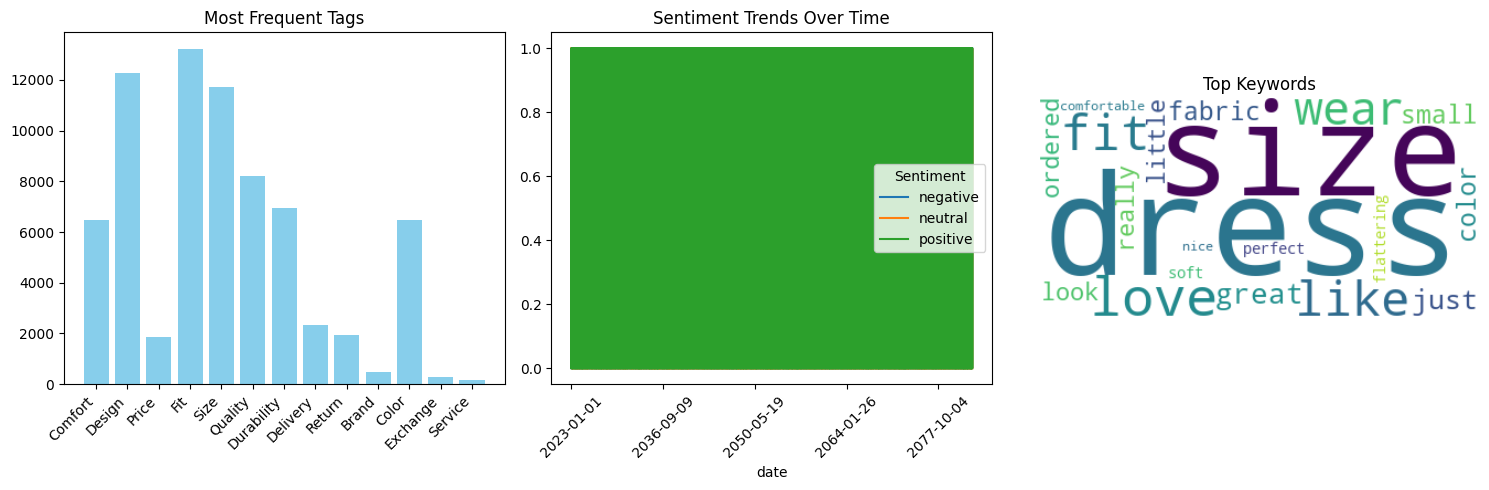

In [16]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from rake_nltk import Rake
import nltk
nltk.download('stopwords')

# Load data
df = pd.read_csv('reviews.csv')

# Drop nulls in Review Text
df = df.dropna(subset=['Review Text'])

# Define tag keywords dictionary
tag_keywords = {
    "Fit": ["tight", "loose", "snug", "fit", "small", "big"],
    "Quality": ["quality", "material", "fabric", "stitch", "durable", "cheap", "fade", "color fade"],
    "Delivery": ["late", "delivery", "shipping", "arrived", "time"],
    "Price": ["price", "expensive", "cheap", "value", "cost"],
    "Design": ["design", "style", "look", "pretty", "beautiful"],
    "Comfort": ["comfortable", "comfy", "itchy", "soft"],
    "Size": ["size", "small", "large", "fits", "sizing"],
    "Color": ["color", "fade", "bright", "dull", "shade"],
    "Brand": ["brand", "logo", "label", "authentic"],
    "Service": ["service", "support", "helpful", "rude", "friendly"],
    "Return": ["return", "refund", "exchange", "policy"],
    "Exchange": ["exchange", "replacement", "swap"],
    "Durability": ["durable", "long-lasting", "wear", "tear", "break"]
}

# Initialize RAKE with stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
rake = Rake(stopwords=stop_words)

# RAKE keyword extraction
def extract_keywords(text):
    rake.extract_keywords_from_text(text)
    return rake.get_ranked_phrases()

df['rake_keywords'] = df['Review Text'].apply(extract_keywords)

# Auto-tagging function using raw text + RAKE keywords
def auto_tag(text, keywords, extracted_keywords):
    tags = set()
    text_lower = text.lower()
    for label, words in keywords.items():
        if any(word in text_lower for word in words):
            tags.add(label)
        if any(word in extracted_keywords for word in words):
            tags.add(label)
    return list(tags)

# Apply auto-tagging
df['tags'] = df.apply(lambda row: auto_tag(row['Review Text'], tag_keywords, row['rake_keywords']), axis=1)

# Keep only rows with tags
df = df[df['tags'].map(len) > 0]

# If sentiment column does not exist, create a dummy one (or you can replace with real sentiment)
if 'sentiment' not in df.columns:
    import random
    df['sentiment'] = df['Review Text'].apply(lambda x: random.choice(['positive','neutral','negative']))

# If no date column, create dummy dates for plotting (replace with your actual date column if available)
if 'date' not in df.columns:
    df['date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D').astype(str)

# Aggregate tag frequency
all_tags = [tag for sublist in df['tags'] for tag in sublist]
tag_counts = Counter(all_tags)

# Sentiment trends over time
sentiment_trends = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Extract top keywords from review texts with CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['Review Text'])
keywords = vectorizer.get_feature_names_out()
keyword_counts = X.toarray().sum(axis=0)

# Plotting
plt.figure(figsize=(15,5))

# 1. Bar chart - Tags frequency
plt.subplot(1,3,1)
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title('Most Frequent Tags')
plt.xticks(rotation=45, ha='right')

# 2. Line chart - Sentiment trends over time
plt.subplot(1,3,2)
sentiment_trends.plot(ax=plt.gca())
plt.title('Sentiment Trends Over Time')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

# 3. Word cloud - Top keywords
plt.subplot(1,3,3)
wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(zip(keywords, keyword_counts)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords')

plt.tight_layout()
plt.show()


In [5]:
# Enhanced text cleaning function with contractions removal and numbers removal
contraction_map = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    # Replace contractions
    for contraction, full_form in contraction_map.items():
        text = re.sub(contraction, full_form, text)
    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", " ", text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize, remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['Review Text'].apply(clean_text)


C:\Users\Shiksha\AppData\Local\Temp\ipykernel_16280\6303915.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis')


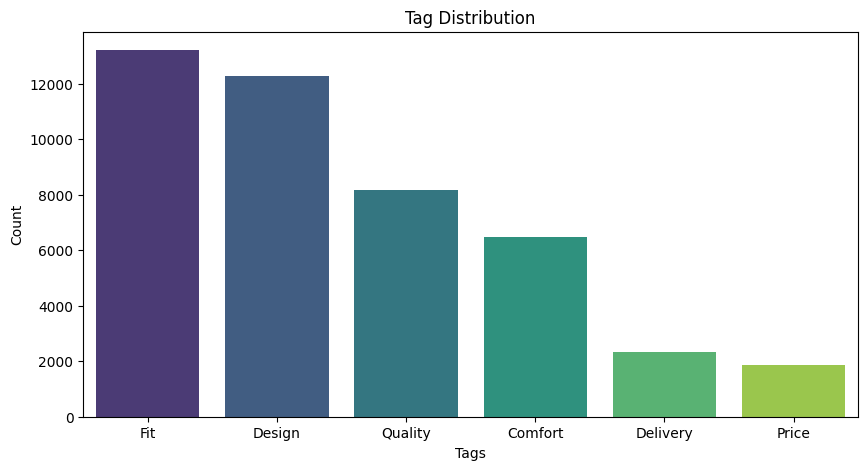

In [6]:
# Visualize tag distribution
tag_counts = pd.Series([tag for sublist in df['tags'] for tag in sublist]).value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis')
plt.title("Tag Distribution")
plt.ylabel("Count")
plt.xlabel("Tags")
plt.show()


In [7]:
# Label binarizer
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['tags'])

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned'])

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
# Model with hyperparameter tuning suggestion
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Optional: Grid Search for best C parameter (commented for speed)
# param_grid = {'estimator__C': [0.1, 1, 10]}
# grid = GridSearchCV(model, param_grid, cv=3, scoring='f1_micro', n_jobs=-1)
# grid.fit(X_train, Y_train)
# print("Best parameters:", grid.best_params_)
# model = grid.best_estimator_

model.fit(X_train, Y_train)

# Evaluate
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


              precision    recall  f1-score   support

     Comfort       1.00      0.94      0.97      1260
    Delivery       1.00      0.65      0.79       456
      Design       1.00      0.99      0.99      2496
         Fit       0.99      0.98      0.98      2633
       Price       1.00      0.68      0.81       379
     Quality       1.00      0.96      0.98      1662

   micro avg       1.00      0.94      0.97      8886
   macro avg       1.00      0.87      0.92      8886
weighted avg       1.00      0.94      0.97      8886
 samples avg       0.99      0.95      0.97      8886



C:\Users\Shiksha\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
joblib.dump(model, '../backend/model.pkl')
joblib.dump(vectorizer, '../backend/vectorizer.pkl')
joblib.dump(mlb, '../backend/mlb.pkl')


['../backend/mlb.pkl']